In [3]:
import pandas as pd
import numpy as np
import re
import ast
from statsmodels.stats.proportion import proportion_confint
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
import json
import ast  # For safely evaluating the string into a Python object
import math
import os
import seaborn as sns
from matplotlib.ticker import FuncFormatter


data = pd.read_csv("filtered_data.csv")

# Preparing data to VosViewer

In [ ]:
my_export = {
    "results": []
}

# List of columns that might contain nested JSON strings
nested_columns = [
    "authorships", "referenced_works", "concepts", "primary_location",
    "counts_by_year", "biblio", "related_works", "abstract_inverted_index",
    "institution_assertions", "best_oa_location", "datasets", "sustainable_development_goals",
    "mesh", "grants", "indexed_in", "topics", "locations"
]

def replace_nan(value, column):
    # Convert "NaN" string to None as well
    if isinstance(value, str) and value.strip().lower() == "nan":
        return None 
    if isinstance(value, float) and math.isnan(value):
        return None
    elif isinstance(value, list):
        return [replace_nan(v, column) for v in value]
    elif isinstance(value, dict):
        return {k: replace_nan(v, column) for k, v in value.items() if replace_nan(v, column) is not None}
    return value

def parse_nested_json(raw_value):
    if raw_value and isinstance(raw_value, str):
        try:
            # Safely parse the string to a Python list/dict
            return ast.literal_eval(raw_value)
        except Exception as e:
            print(f"Error parsing value: {e}")
            return None  # Default to None if parsing fails
    return raw_value

for index, row in data.iterrows():
    record = {}
    for column in data.columns:
        raw_value = row.get(column, None)
        if column in nested_columns:
            parsed_value = parse_nested_json(raw_value)
            record[column] = replace_nan(parsed_value, column)
        else:
            record[column] = replace_nan(raw_value, column)
    my_export["results"].append(record)

# Save to JSON file
with open("../../data/VosViewer.json", "w") as json_file:
    json.dump(my_export, json_file, indent=4)

# Print unique "id" count
unique_ids_count = data['id'].value_counts().sum()
print(unique_ids_count)

15033


In [7]:
data_export = pd.read_csv("../../data/data_export.csv")

In [8]:
# Merge the dataframes on 'id'
merged_data = data.merge(data_export[['id', 'authors', 'journal_name', 'countries']], on='id', how='left')

# Inserting category into mappings

### 1. Authors

In [157]:
# Split authors so only 1 author per row
merged_data['authors'] = merged_data['authors'].apply(lambda x: x.replace("'", "").replace("[", "").replace("]", "").lower().split(', '))
merged_data = merged_data.explode('authors')

# Get most frequent category per author
df_categories = merged_data.groupby('authors')['predicted_category'] \
    .agg(lambda x: x.value_counts().index[0]) \
    .reset_index()

category_map = {
    "Psychology": 7, "Innovative Technologies": 1, "Physical Attributes": 2, "Scouting / Finance": 3,
    "Other": 4, "Medical / Injuries": 5, "Tactics analysis": 6
}

df_categories['category_int'] = df_categories['predicted_category'].map(category_map)

df_categories = df_categories.rename(columns={'authors': 'author_name', 'predicted_category': 'category'})

df_categories.to_csv("author_categories.csv", index=False)

### 2. Journals

In [158]:
# Split journal names so only 1 journal name per row
merged_data['journal_name'] = merged_data['journal_name'].apply(lambda x: str(x).replace("'", "").replace("[", "").replace("]", "").lower().split(', ') if isinstance(x, str) else [])
merged_data = merged_data.explode('journal_name')

# Get most frequent category per journal name
df_categories = merged_data.groupby('journal_name')['predicted_category'] \
    .agg(lambda x: x.value_counts().index[0]) \
    .reset_index()

category_map = {
    "Psychology": 7, "Innovative Technologies": 1, "Physical Attributes": 2, "Scouting / Finance": 3,
    "Other": 4, "Medical / Injuries": 5, "Tactics analysis": 6
}

df_categories['category_int'] = df_categories['predicted_category'].map(category_map)

df_categories = df_categories.rename(columns={'journal_name': 'journal_name', 'predicted_category': 'category'})

df_categories.to_csv("journal_categories.csv", index=False)

### 3. Countries

In [159]:
# Split countries so only 1 country per row
merged_data['countries'] = merged_data['countries'].apply(lambda x: x.replace("'", "").replace("[", "").replace("]", "").lower().split(', '))
merged_data = merged_data.explode('countries')

# Get most frequent category per country
df_categories = merged_data.groupby('countries')['predicted_category'] \
    .agg(lambda x: x.value_counts().index[0]) \
    .reset_index()

category_map = {
    "Psychology": 7, "Innovative Technologies": 1, "Physical Attributes": 2, "Scouting / Finance": 3,
    "Other": 4, "Medical / Injuries": 5, "Tactics analysis": 6
}

df_categories['category_int'] = df_categories['predicted_category'].map(category_map)

df_categories = df_categories.rename(columns={'countries': 'country_name', 'predicted_category': 'category'})

df_categories.to_csv("country_categories.csv", index=False)

### Inserting into map csv
Have to do this step for each new graph

In [220]:
map_df = pd.read_csv("maps_and_networks/map_top300_authors.csv")

# Merge df_categories with map_df on country_name and label
merged_df = map_df.merge(df_categories, left_on='label', right_on='author_name', how='left')

# Replace cluster with category_int
merged_df['cluster'] = merged_df['category_int']

# Drop unnecessary columns
merged_df = merged_df.drop(columns=['author_name', 'category', 'category_int'])

# Save the updated map.csv
merged_df.to_csv("map_updated.csv", index=False)

In [161]:
merged_df['cluster'].isna().sum()


1

# Visuals

### 1. Citation average in each category

In [9]:
category_citation_stats = merged_data.groupby('predicted_category')['cited_by_count'] \
    .mean() \
    .sort_values(ascending=False)

print(category_citation_stats)

predicted_category
Tactics analysis           11.602740
Medical / Injuries          9.260295
Psychology                  8.991071
Physical Attributes         8.949855
Innovative Technologies     7.255992
Scouting / Finance          6.094709
Other                       5.687867
Name: cited_by_count, dtype: float64


In [10]:
category_citation_stats = merged_data.groupby('predicted_category')['cited_by_count'] \
    .sum() \
    .sort_values(ascending=False)

print(category_citation_stats)

predicted_category
Physical Attributes        49260
Medical / Injuries         23836
Innovative Technologies    15136
Scouting / Finance         11519
Tactics analysis           11011
Psychology                  9063
Other                       5813
Name: cited_by_count, dtype: int64


Needs data from "categories_processing" and "VosViewer data"

In [ ]:
base_path = "maps_and_networks"
map_file = os.path.join(base_path, "map_all_authors.csv")
net_file = os.path.join(base_path, "network_all_authors.csv")
cat_file = "author_categories.csv"

# 1. Load author–ID map
df_map = pd.read_csv(map_file) 

# 2. Merge with author_categories
df_cat = pd.read_csv(cat_file)  
df_author_cat = df_map.merge(df_cat, left_on="label", right_on="author_name", how="left")

# 3. Load network and merge with author–category
df_net = pd.read_csv(net_file, header=None, names=["author_id_1", "author_id_2", "link_strength"])
df_author_cat = df_author_cat.rename(columns={'id': 'author_id'})


df_net_cat = df_net \
    .merge(df_author_cat[["author_id", "category"]], left_on="author_id_1", right_on="author_id", how="left") \
    .rename(columns={"category": "category_1"}) \
    .drop(columns="author_id")
df_net_cat = df_net_cat \
    .merge(df_author_cat[["author_id", "category"]], left_on="author_id_2", right_on="author_id", how="left") \
    .rename(columns={"category": "category_2"}) \
    .drop(columns="author_id")

df_net_cat['category_1'] = df_net_cat['category_1'].fillna('Unknown').astype(str)
df_net_cat['category_2'] = df_net_cat['category_2'].fillna('Unknown').astype(str)
df_net_cat = df_net_cat[df_net_cat['category_1'] != 'Unknown']
df_net_cat = df_net_cat[df_net_cat['category_2'] != 'Unknown']

df_net_cat['ordered_pair'] = df_net_cat.apply(
    lambda row: tuple(sorted([row['category_1'], row['category_2']])), axis=1
)




df_collab = df_net_cat.groupby('ordered_pair').size().reset_index(name='collaborations')
df_collab['collaborations'] = df_collab['collaborations']
df_collab[['category_1', 'category_2']] = pd.DataFrame(df_collab['ordered_pair'].tolist(), index=df_collab.index)
df_collab = df_collab.drop(columns='ordered_pair')
df_collab = df_collab.sort_values(by="collaborations", ascending=False)

df_collab['category_1_contribution'] = df_collab.apply(
    lambda row: row['collaborations'], axis=1
)
df_collab['category_2_contribution'] = df_collab.apply(
    lambda row: row['collaborations'] if row['category_1'] != row['category_2'] else 0, axis=1
)

# Prepare a long-form dataframe to sum by categories
df_long = pd.concat([
    df_collab[['category_1', 'category_1_contribution']].rename(
        columns={'category_1': 'category', 'category_1_contribution': 'contribution'}),
    df_collab[['category_2', 'category_2_contribution']].rename(
        columns={'category_2': 'category', 'category_2_contribution': 'contribution'})
])

# Group by category and sum contributions
df_total_collab = df_long.groupby('category')['contribution'].sum().reset_index()
df_total_collab = df_total_collab.rename(columns={'contribution': 'total_collaborations'})

# Sort by total collaborations for clarity
df_total_collab = df_total_collab.sort_values(by='total_collaborations', ascending=False)

# for each row in df_collab find percentage compared to total collaborations for both categories
df_collab = df_collab.merge(df_total_collab, left_on='category_1', right_on='category', how='left') \
    .rename(columns={'total_collaborations': 'total_collaborations_1'}) \
    .drop(columns='category')
df_collab = df_collab.merge(df_total_collab, left_on='category_2', right_on='category', how='left') \
    .rename(columns={'total_collaborations': 'total_collaborations_2'}) \
    .drop(columns='category')

df_collab['category_1_percentage'] = df_collab.apply(
    lambda row: row['category_1_contribution'] / row['total_collaborations_1'], axis=1
)
df_collab['category_2_percentage'] = df_collab.apply(
    lambda row: row['category_2_contribution'] / row['total_collaborations_2'], axis=1
)

df_collab.head()

In [165]:
unique_categories = df_net_cat['category_1'].unique()

results = []

# Loop through each category
for cat_name in unique_categories:
    # 1) Filter to pairs where this category is involved
    df_physical = df_net_cat[
        (df_net_cat['category_1'] == cat_name) |
        (df_net_cat['category_2'] == cat_name)
    ]

    # 2) Count total collabs for the current category only
    total_for_physical = len(df_physical)  # or sum link_strength if you want weighting

    # 3) Group by the *other* category to see distribution
    df_physical_dist = (
        df_physical.assign(
            other_category=lambda d: d.apply(
                lambda row: row['category_2'] if row['category_1'] == cat_name else row['category_1'],
                axis=1
            )
        )
        .groupby('other_category')
        .size()
        .reset_index(name='collaborations')
    )

    # 4) Compute fraction
    df_physical_dist['fraction_of_total'] = (
        df_physical_dist['collaborations'] / total_for_physical
    )

    # Add the category name to the dataframe
    df_physical_dist['category'] = cat_name

    # Append the result to the list
    results.append(df_physical_dist)

# Concatenate all results into a single dataframe
df_all_categories = pd.concat(results, ignore_index=True)


df_all_categories.head(10)


,other_category,collaborations,fraction_of_total,category
0,Innovative Technologies,180,0.042046,Psychology
1,Medical / Injuries,635,0.148330,Psychology
2,Other,46,0.010745,Psychology
3,Physical Attributes,1221,0.285214,Psychology
4,Psychology,1717,0.401075,Psychology
5,Scouting / Finance,233,0.054427,Psychology
6,Tactics analysis,249,0.058164,Psychology
7,Innovative Technologies,729,0.022734,Physical Attributes
8,Medical / Injuries,3774,0.117695,Physical Attributes
9,Other,132,0.004117,Physical Attributes


In [ ]:
# 1) Pivot so rows are 'category' and columns are 'other_category' 
df_stacked = df_all_categories.pivot(
    index='category',
    columns='other_category',
    values='fraction_of_total'
)

colors = sns.color_palette("colorblind", len(df_stacked.columns))

collab_sums = df_all_categories.groupby('category')['collaborations'].sum().sort_values(ascending=False)

df_stacked = df_stacked.loc[collab_sums.index]

# 2) Convert fractions to percentages
df_stacked_percent = df_stacked * 100

ax = df_stacked_percent.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 8),
    color=colors,
    alpha=0.8
)

# 3) Format the plot
ax.set_xlabel("Category")
ax.set_ylabel("Collaboration")
plt.ylim(0, 100) 

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}%'))

plt.yticks(np.arange(0, 101, 100))
plt.xticks(rotation=45, ha='right')
plt.legend(title='Other Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

ax.grid(False)

for container in ax.containers:
    ax.bar_label(container, labels=[f'{v:.1f}%' if v > 12 else '' for v in container.datavalues], label_type='center', color='white')

new_labels = [
    f'{category} (collaborations: {collab_sums.get(category, 0)})' if idx == 0 else f'{category}({collab_sums.get(category, 0)})'
    for idx, category in enumerate(df_stacked.index)
]
ax.set_xticklabels(new_labels)

plt.tight_layout()
plt.savefig("co-author_percent.jpg", dpi=400)
plt.show()

/var/folders/12/sch4w1bj79q33lp95mcccx700000gn/T/ipykernel_84507/1314082864.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return data.applymap(lambda x: f'{x:.2f}%')


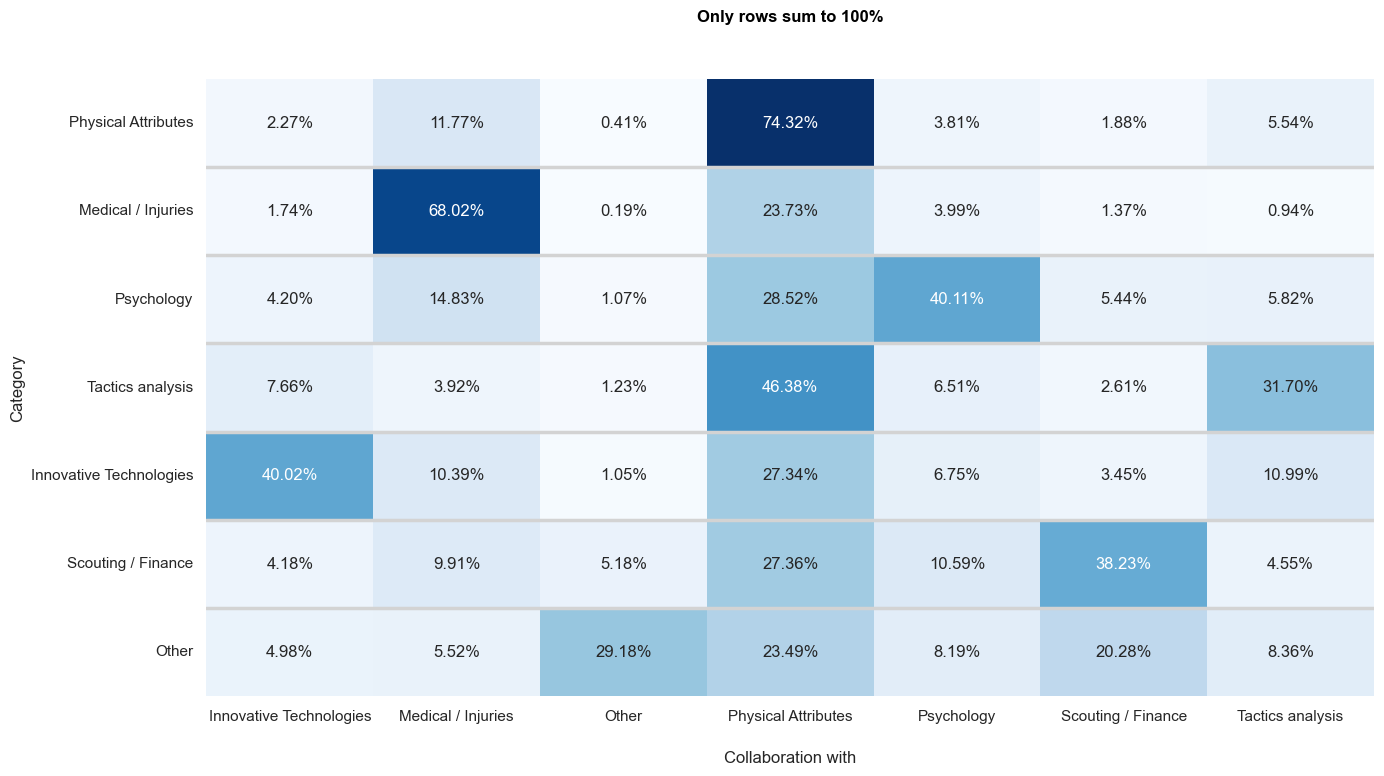

In [218]:
df_normalized = df_stacked.div(df_stacked.sum(axis=1), axis=0) * 100

plt.figure(figsize=(14, 8))

def annot_format(data):
    return data.applymap(lambda x: f'{x:.2f}%')

ax = sns.heatmap(df_normalized, cmap="Blues", annot=annot_format(df_normalized), fmt="", cbar=False)
plt.xlabel("Collaboration with", labelpad=20) 
plt.ylabel("Category")
plt.yticks(rotation=0)
plt.tight_layout()

for i in range(1, df_normalized.shape[0]):
    ax.axhline(i, color='lightgrey', lw=2.5)

plt.text(len(df_normalized.columns) / 2, -0.7, 'Only rows sum to 100%', ha='center', va='center', fontsize=12, color='black', fontweight='bold')
plt.tight_layout()
plt.savefig("co-author_percent.jpg", dpi=400)
plt.show()